<img align="left" src="https://raw.githubusercontent.com/sokjc/WinnersCircle/master/assets/WinnersCircle-small-icononly.png" width=200 />

## Winner's Circle: RL Workshop

# Part 03: Deep Q-Learning
Inspired by the Deep Mind Paper ["Playing Atari with Deep Reinforcement Learning"](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf), this section will introduce a popular strategy for RL and layer a complication with the Double Deep Q-Learning (DDQN). Most of the code and instructional material is directly adapted from Greg Surma's medium series on Solving Games with AI. 

The goal of this session will be to introduce you to an algorithm that can successfuly play any game by pixels alone. 

DQN is a RL technique that is aimed at choosing the best action for given circumstances (observation). Each possible action for each possible observation has its Q value, where 'Q' stands for a quality of a given move. But how do we end up with accurate Q values? Enter deep neural networks.

For each state experienced by the agent, the algorithm remebers it. The algo then replays the experience by sampling experiences from memory and updating is Q value.

## Data Preparation

Since all Atari games have pixels, we can use them to generalize a model across games instead of creating a model speficic to each game world. 

### Observations

Consider one frame:

<img src="https://cdn-images-1.medium.com/max/1600/1*uQn5fCSJ4u4F0dXyhu2bpw.png" width=200px />

**Group Discussion**

* Is one frame enough for our to predict what to do? 
* Or do we need more information?

Now consider four frames: 

<img src="https://cdn-images-1.medium.com/max/1600/1*r_zU8YRUSSr56E0Wr9ZQcQ.png" width=800px />

**Group Discussion**

* Why might four frames be better?
* What are the draw backs of using four frames as single observation?

### Resizing the Observations
Four frames of 210x160 RGB arrays that Attari outputs is a lot of information for our model to handle. Let's do two preprocessing steps: change the images to greyscale and scale downscale the size of over all image. Our final array will be 84x84x4 - much easier to handle.

<img src="https://cdn-images-1.medium.com/max/1600/1*ChDEq-Leap9J5T5h6nYBzg.png" width=800px />

## Convolutional Neural Network

We will be using the architecture from the Deep Mind Paper: 

<img src="https://cdn-images-1.medium.com/max/1600/1*3ZgGbUpEyAZb9POWijRq4Q.png" />

In [1]:
%cd /notebooks/WinnersCircle

/Users/jsokoll/Documents/WinnersCircle


In [2]:
import gym
import numpy as np
from game_models.ddqn import DDQNTrainer, DDQNSolver
from game_models.ge import GETrainer, GESolver
from gym_wrappers import MainGymWrapper

# Plotting
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
FRAMES_IN_OBSERVATION = 4
FRAME_SIZE = 84
INPUT_SHAPE = (FRAMES_IN_OBSERVATION, FRAME_SIZE, FRAME_SIZE)

In [4]:
class Atari: 
    
    def __init__(self, game_name, game_mode, render=False, total_step_limit=500000, total_run_limit=None, clip=True):

        env_name = game_name + "Deterministic-v4" #Handles frame skippings (4) at every iteration
        env = MainGymWrapper.wrap(gym.make(env_name))
        self._main_loop(self._game_model(game_mode, game_name, env.action_space.n), env, render, total_step_limit, total_run_limit, clip)
        
    def _main_loop(self, game_model, env, render, total_step_limit, total_run_limit, clip):
        if isinstance(game_model, GETrainer):
            game_model.genetic_evolution(env)

        run = 0
        total_step = 0
        while True:
            if total_run_limit is not None and run >= total_run_limit:
                print("Reached total run limit of: " + str(total_run_limit))
                exit(0)

            run += 1
            current_state = env.reset()
            
            if render:
                img = plt.imshow(env.render(mode='rgb_array'))
                
            step = 0
            score = 0
            while True:
                if total_step >= total_step_limit:
                    print("Reached total step limit of: " + str(total_step_limit))
                    exit(0)
                total_step += 1
                step += 1

                if render:
                    img.set_data(env.render(mode='rgb_array')) # just update the data
                    display.display(plt.gcf())
                    display.clear_output(wait=True)

                action = game_model.move(current_state)
                next_state, reward, terminal, info = env.step(action)
                if clip:
                    np.sign(reward)
                score += reward
                game_model.remember(current_state, action, reward, next_state, terminal)
                current_state = next_state

                game_model.step_update(total_step)

                if terminal:
                    game_model.save_run(score, step, run)
                    break
        
    def _game_model(self, game_mode,game_name, action_space):
        if game_mode == "ddqn_training":
            return DDQNTrainer(game_name, INPUT_SHAPE, action_space)
        elif game_mode == "ddqn_testing":
            return DDQNSolver(game_name, INPUT_SHAPE, action_space)

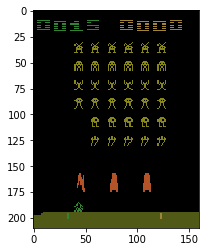

In [ ]:
Atari('SpaceInvaders', 'ddqn_training', render=True)

## References

* Surma, Greg. [*__Cartpole - Introduction to Reinforcement Learning (DQN - Deep Q-Learning): Solving OpenAI Gym Environment__*](https://towardsdatascience.com/cartpole-introduction-to-reinforcement-learning-ed0eb5b58288). 26 September, 2018.